<a href="https://colab.research.google.com/github/Van-Wu1/cycle/blob/main/scr/py/env.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# 这个就是drive里面的文件路径
!ls '/content/drive/MyDrive/CASA0004_Cycling/data'

BoroughShp
city_of_london_bike_accessible_roads.geojson
COL_cycleavailable.geojson
COL_cyclelane.geojson
Env
greater_london_bike_accessible_roads.geojson
GreatLondonShp
Roads
Slope


## 基础导入啥的

In [3]:
import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
from shapely.strtree import STRtree

## 1.gvi

The GVI dataset used in this study is derived from the Treepedia project (MIT, 2015), based on Google Street View images captured around 2015. While this may not fully reflect recent greening interventions or urban modifications, GVI is used here as a general proxy for the visual landscape structure. Limitations related to data currency are discussed in Section X.

本研究所用GVI数据来自于MIT Treepedia项目，基于约2015年的Google街景图像。尽管可能无法反映最近绿化或街景变化，但其作为城市空间绿意结构的代表性指标，仍具有参考价值，相关时效性局限将在后文讨论部分说明。

To address gaps in GVI coverage along street segments, a borough-level imputation strategy was applied. Each road segment was first assigned a GVI value based on the average of nearby GVI points within a 20-meter buffer. For segments lacking any such points, the mean GVI value of the corresponding Greater London borough was used as a proxy. All imputed values were flagged to ensure transparency and to support subsequent interpretation.

为解决街道路段内 GVI 数据覆盖不足的问题，本研究采用了基于 Borough（伦敦行政区）划分的分组插值策略。首先，优先使用 20 米缓冲区内的 GVI 点均值赋值给道路段；若缓冲区内未找到任何 GVI 点，则根据该路段所在 Borough 的平均 GVI 值进行插值补全。所有插值段均被标记，以保证分析过程的透明性和后续结果解释的严谨性。

### 先导入一下数据（一直出错啊妈的

In [4]:
boroughs_gdf = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/BoroughShp/borough/borough.shp")
print(boroughs_gdf.columns)

edges_gdf = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/Roads/london_edges_FIXED.gpkg")
print(edges_gdf.columns)

gvi_points = gpd.read_file("/content/drive/MyDrive/CASA0004_Cycling/data/Env/greenview_london.json/greenview_london.json")
print(gvi_points.columns)

Index(['NAME', 'GSS_CODE', 'HECTARES', 'NONLD_AREA', 'ONS_INNER', 'SUB_2009',
       'SUB_2006', 'geometry'],
      dtype='object')
Index(['u', 'v', 'key', 'osmid', 'access', 'highway', 'maxspeed', 'name',
       'oneway', 'reversed', 'length', 'lanes', 'ref', 'bridge', 'junction',
       'tunnel', 'width', 'service', 'est_width', 'area', 'geometry'],
      dtype='object')
Index(['FID', 'PntNum', 'panoID', 'panoDate', 'greenView', 'geometry'], dtype='object')


In [5]:
projected_crs = "EPSG:27700"
edges_gdf = edges_gdf.to_crs(projected_crs)
boroughs_gdf = boroughs_gdf.to_crs(projected_crs)
gvi_points = gvi_points.to_crs(projected_crs)

In [6]:
boroughs_gdf = boroughs_gdf[['NAME', 'geometry']].rename(columns={'NAME': 'name'})

In [7]:
# 将 GVI 点赋值给 Borough（我们之后要 fallback）
gvi_points = gvi_points.to_crs(boroughs_gdf.crs)
gvi_with_borough = gpd.sjoin(gvi_points, boroughs_gdf, how='inner', predicate='within')

# 计算 Borough 的平均 GVI 值
borough_gvi_mean = gvi_with_borough.groupby('name')['greenView'].mean().to_dict()
print(borough_gvi_mean)

{'Barking and Dagenham': 9.956715211543225, 'Barnet': 17.183731562227795, 'Bexley': 12.555201401160128, 'Brent': 13.387036045154845, 'Bromley': 17.490392798331015, 'Camden': 15.705790953840856, 'City of London': 6.078575598230088, 'Croydon': 17.42361365029124, 'Ealing': 14.22662851005025, 'Enfield': 14.374663562873259, 'Greenwich': 15.130032851144279, 'Hackney': 11.230470191756273, 'Hammersmith and Fulham': 12.67179935098781, 'Haringey': 14.22248786059309, 'Harrow': 14.789230103879849, 'Havering': 13.943786303221732, 'Hillingdon': 16.309627819518948, 'Hounslow': 14.003835840731503, 'Islington': 13.337145922688226, 'Kensington and Chelsea': 13.010757235919234, 'Kingston upon Thames': 15.40256658454591, 'Lambeth': 13.578280558524852, 'Lewisham': 13.024022477114041, 'Merton': 15.501925656580617, 'Newham': 11.146743481980197, 'Redbridge': 12.134484017713365, 'Richmond upon Thames': 18.68832873456003, 'Southwark': 14.326239796140351, 'Sutton': 17.120068456362556, 'Tower Hamlets': 12.8026552

In [8]:
import geopandas as gpd
import pandas as pd
from tqdm.notebook import tqdm
tqdm.pandas()

# === 0. 只抽取前 3000 条边作为测试集 ===
# edges_final = edges_gdf.iloc[:10000].copy()
# 改为全部
edges_final = edges_gdf

# === 1. 创建每条路段的中点列 ===
print("1begin")
edges_final['midpoint'] = edges_final.geometry.interpolate(0.5, normalized=True)
midpoints_gdf = gpd.GeoDataFrame(edges_final[['midpoint']], geometry='midpoint', crs=edges_final.crs)

# === 2. 建立 GVI 空间索引，提升效率 ===
print("2begin")
gvi_points = gvi_points.to_crs(edges_final.crs)
gvi_sindex = gvi_points.sindex

# === 3. 对每条道路构建 30 米缓冲区并查找 GVI 点 ===
print("3begin")
def compute_gvi_buffer_mean(point):
    buffer = point.buffer(30)
    possible = list(gvi_sindex.intersection(buffer.bounds))
    near = gvi_points.iloc[possible]
    near = near[near.intersects(buffer)]
    if len(near) > 0:
        return near['greenView'].mean()
    else:
        return None

midpoints_gdf['gvi_buffer_mean'] = midpoints_gdf['midpoint'].progress_apply(compute_gvi_buffer_mean)

# === 4. 给中点赋 Borough 标签，用于 fallback ===
print("4begin")
midpoints_with_borough = gpd.sjoin(midpoints_gdf, boroughs_gdf, how='left', predicate='within')
midpoints_with_borough['borough'] = midpoints_with_borough['name']

# === 5. 建立最终 gvi 值和标记列 ===
print("5begin")
def assign_final_gvi(row):
    if pd.notnull(row['gvi_buffer_mean']):
        return row['gvi_buffer_mean'], 0
    else:
        borough = row['borough']
        return borough_gvi_mean.get(borough, None), 1

midpoints_with_borough[['gvi_final', 'gvi_flag']] = midpoints_with_borough.apply(assign_final_gvi, axis=1, result_type='expand')

# === 6. 合并结果回 edges_final ===
print("6begin")
edges_final['gvi_final'] = midpoints_with_borough['gvi_final']
edges_final['gvi_flag'] = midpoints_with_borough['gvi_flag']

1begin
2begin
3begin


  0%|          | 0/292703 [00:00<?, ?it/s]

4begin
5begin
6begin


In [12]:
print(edges_final.columns)

Index(['u', 'v', 'key', 'osmid', 'access', 'highway', 'maxspeed', 'name',
       'oneway', 'reversed', 'length', 'lanes', 'ref', 'bridge', 'junction',
       'tunnel', 'width', 'service', 'est_width', 'area', 'geometry',
       'midpoint', 'gvi_final', 'gvi_flag'],
      dtype='object')


In [13]:
# 删除多余的几何列（比如 midpoint）
edges_final = edges_final.drop(columns=['midpoint'])
edges_final.set_geometry('geometry', inplace=True)

In [14]:
edges_final.to_file("edges_with_gvi.gpkg", driver="GPKG")  # 若要输出为 GeoJSON 改为 driver="GeoJSON"
edges_final.to_file("edges_with_gvi.geojson", driver="GeoJSON") # 输出为 GeoJSON 格式

print("导出成功")

导出成功


In [15]:
# 统计 gvi_flag 各值的数量
flag_counts = edges_final['gvi_flag'].value_counts().sort_index()

# 输出结果
print("GVI 标记值统计结果：")
for flag in flag_counts.index:
    count = flag_counts[flag]
    ratio = count / len(edges_final) * 100
    label = "缓冲区内有真实GVI点" if flag == 0 else "使用 Borough 平均值估算"
    print(f"  gvi_flag = {flag} ：{count} 条道路（{ratio:.2f}%） → {label}")

GVI 标记值统计结果：
  gvi_flag = 0.0 ：140667 条道路（48.06%） → 缓冲区内有真实GVI点
  gvi_flag = 1.0 ：152036 条道路（51.94%） → 使用 Borough 平均值估算


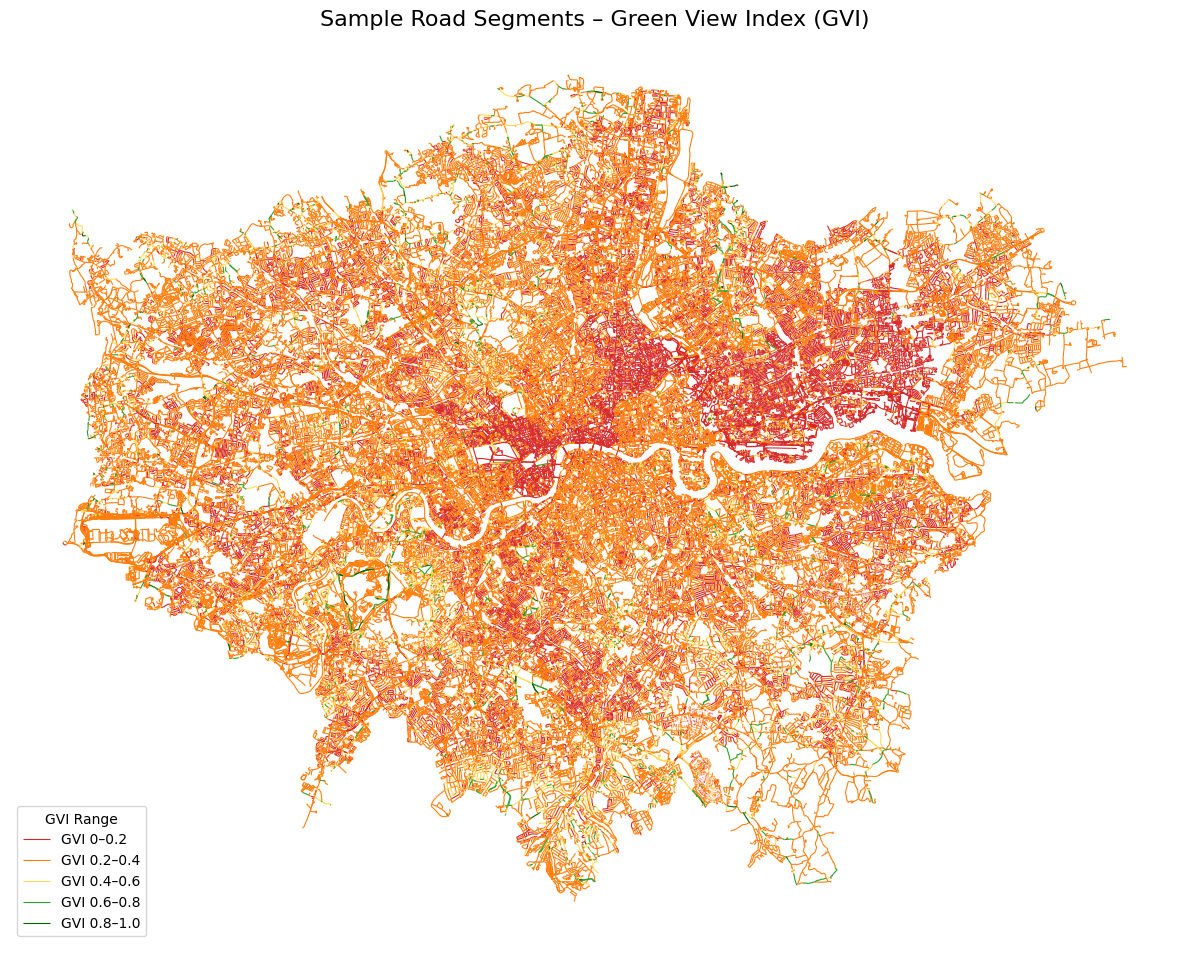

In [16]:
import matplotlib.pyplot as plt
import pandas as pd

# 自定义 GVI 分级颜色（从低到高）
gvi_bins = [0.0, 0.2, 0.4, 0.6, 0.8, 1.0]
gvi_colors = ['#d62728', '#ff7f0e', '#ffdb58', '#2ca02c', '#006400']
gvi_labels = ['0–0.2', '0.2–0.4', '0.4–0.6', '0.6–0.8', '0.8–1.0']

# 步骤 1：归一化
edges_final['gvi_final_norm'] = edges_final['gvi_final'] / edges_final['gvi_final'].max()

# 步骤 2：分组
edges_final['gvi_group'] = pd.cut(
    edges_final['gvi_final_norm'],
    bins=gvi_bins,
    labels=gvi_labels,
    include_lowest=True
)

# 步骤 3：绘图
fig, ax = plt.subplots(figsize=(12, 12))
for label, color in zip(gvi_labels, gvi_colors):
    subset = edges_final[edges_final['gvi_group'] == label]
    if not subset.empty:
        subset.plot(ax=ax, color=color, linewidth=0.8, label=f'GVI {label}')

# 美化图形
ax.set_title("Sample Road Segments – Green View Index (GVI)", fontsize=16)
ax.set_axis_off()
ax.legend(title="GVI Range", loc='lower left')
plt.tight_layout()
plt.show()

#备用一个
edges_copy = edges_final

<Axes: >

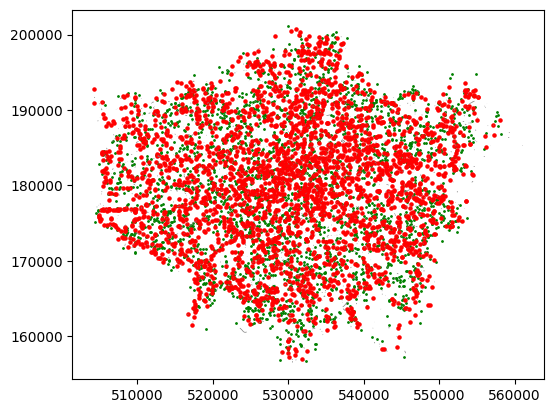

In [17]:
ax = edges_gdf.sample(3000).plot(color='gray', linewidth=0.5)
gvi_points.sample(3000).plot(ax=ax, color='green', markersize=1)
midpoints_gdf.sample(3000).plot(ax=ax, color='red', markersize=5)

### 然后做一下第二部分的AQI

In [18]:
# !pip install rasterstats
!pip install rasterio geopandas rasterstats

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.6/56.6 kB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.2/22.2 MB 85.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 89.6 MB/s eta 0:00:00


In [19]:
import geopandas as gpd
import rasterio
from rasterio.mask import mask
from rasterstats import zonal_stats
import json

In [20]:
NO2 = '/content/drive/MyDrive/CASA0004_Cycling/data/Env/NO2/AQI.tif'
with rasterio.open(NO2) as src:
    no2_array = src.read(1)
    meta = src.meta

print(no2_array.shape)
print(meta)


(2253, 2918)
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': 3.3999999521443642e+38, 'width': 2918, 'height': 2253, 'count': 1, 'crs': CRS.from_wkt('PROJCS["OSGB36 / British National Grid",GEOGCS["OSGB36",DATUM["Ordnance_Survey_of_Great_Britain_1936",SPHEROID["Airy 1830",6377563.396,299.3249646,AUTHORITY["EPSG","7001"]],AUTHORITY["EPSG","6277"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4277"]],PROJECTION["Transverse_Mercator"],PARAMETER["latitude_of_origin",49],PARAMETER["central_meridian",-2],PARAMETER["scale_factor",0.9996012717],PARAMETER["false_easting",400000],PARAMETER["false_northing",-100000],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AXIS["Easting",EAST],AXIS["Northing",NORTH],AUTHORITY["EPSG","27700"]]'), 'transform': Affine(20.0, 0.0, 503590.0,
       0.0, -20.0, 200930.0)}


In [21]:
# 🚴 直接用整张 NO₂ 栅格进行 zonal overlay
print("🚀 正在批量计算 NO₂ 平均值（矢量化方式）...")

# 统一坐标系为 EPSG:27700（LAEI 栅格用的 BNG 投影）
edges_final = edges_final.to_crs('EPSG:27700')

# 执行 zonal_stats
zs = zonal_stats(edges_final, NO2, stats=['mean'], geojson_out=False)

# 加入结果列
edges_final['NO2_mean'] = [item['mean'] for item in zs]

print("处理完成，共赋值：", len(zs), "条道路段")

🚀 正在批量计算 NO₂ 平均值（矢量化方式）...
处理完成，共赋值： 292703 条道路段


In [22]:
# 查看值分布
print(edges_final['NO2_mean'].describe())

count    292125.000000
mean         21.247719
std           4.865328
min          12.893730
25%          18.010975
50%          20.144176
75%          23.153086
max          87.332474
Name: NO2_mean, dtype: float64


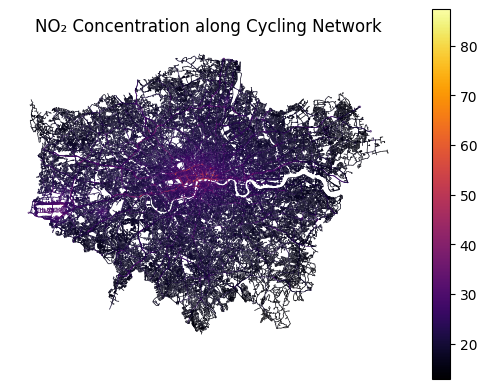

In [23]:
edges_final.plot(column='NO2_mean', cmap='inferno', linewidth=0.5, legend=True)
plt.title('NO₂ Concentration along Cycling Network')
plt.axis('off')
plt.show()

In [24]:
edges_final.to_file("edges_gvi_no2.gpkg", driver="GPKG")  # 若要输出为 GeoJSON 改为 driver="GeoJSON"
edges_final.to_file("edges_gvi_no2.geojson", driver="GeoJSON") # 输出为 GeoJSON 格式

print("导出成功")

导出成功


### 嗯嗯做一下10

In [25]:
# 加载自然特征 shapefile
natural = gpd.read_file('/content/drive/MyDrive/CASA0004_Cycling/data/Env/nature_features/greater_london_nature_features.shp')

# 确保投影一致（使用 EPSG:27700 英国国家网格）
natural = natural.to_crs('EPSG:27700')
edges_final = edges_final.to_crs('EPSG:27700')

In [26]:
# 建立缓冲区（单位为米）
natural_buffer = natural.buffer(50)

# 创建一个新的 GeoDataFrame（必要）
natural_buffer_gdf = gpd.GeoDataFrame(geometry=natural_buffer, crs='EPSG:27700')

In [27]:
# 判断每条路是否与缓冲区相交，返回 True/False 列表
intersects = edges_final.geometry.intersects(natural_buffer_gdf.unary_union)

# 添加新字段 natural_feature，1 表示被覆盖，0 表示不被覆盖
edges_final['natural_feature'] = intersects.astype(int)

/tmp/ipython-input-27-2242247040.py:2: DeprecationWarning: The 'unary_union' attribute is deprecated, use the 'union_all()' method instead.
  intersects = edges_final.geometry.intersects(natural_buffer_gdf.unary_union)


In [28]:
print(edges_final.columns)

Index(['u', 'v', 'key', 'osmid', 'access', 'highway', 'maxspeed', 'name',
       'oneway', 'reversed', 'length', 'lanes', 'ref', 'bridge', 'junction',
       'tunnel', 'width', 'service', 'est_width', 'area', 'geometry',
       'gvi_final', 'gvi_flag', 'gvi_final_norm', 'gvi_group', 'NO2_mean',
       'natural_feature'],
      dtype='object')


In [29]:
edges_final.to_file("edges_gvi_no2_nf.gpkg", driver="GPKG")  # 若要输出为 GeoJSON 改为 driver="GeoJSON"
edges_final.to_file("edges_gvi_no2_nf.geojson", driver="GeoJSON") # 输出为 GeoJSON 格式

print("导出成功")

导出成功
